In [2]:
import re
import string

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('inputs/Dimension-covid.csv')
data.head()

,Date added,Trial ID,Title,Brief title,Acronym,Abstract,Publication date,Active years,Phase,Conditions,...,Gender,Registry,Investigators/Contacts,Sponsors/Collaborators,GRID IDs,Country of Sponsor/Collaborator,Collaborating Funders,Funder Country,Source Linkout,Dimensions URL
0,2021-06-04,NCT04912934,The Relationship Between Coronavirus Anxiety L...,The Relationship Between COVID-19 Anxiety Leve...,COVID-19,The aim was to determine the coronavirus anxie...,2020-06-20,2020,NaN,COVID-19; Emotional Eating; Metabolic Syndrome,...,All,ClinicalTrials.gov,Dilek Küçük Alemdar,Ordu University,grid.412366.4,Turkey,NaN,NaN,https://clinicaltrials.gov/show/NCT04912934,https://app.dimensions.ai/details/clinical_tri...
1,2021-06-04,NCT04912921,Effect of Palmitoylethanolamide on Proinflamma...,Effect of Palmitoylethanolamide on Proinflamma...,NaN,This is a randomized controlled trial to exami...,2020-10-20,2020; 2021; 2022,NaN,COVID19; Inflammation,...,All,ClinicalTrials.gov,NaN,Arizona State University,grid.215654.1,United States,NaN,NaN,https://clinicaltrials.gov/show/NCT04912921,https://app.dimensions.ai/details/clinical_tri...
2,2021-06-04,NCT04912895,Detection of SARS-CoV-2 RNA and Biomarkers in ...,Detection of SARS-CoV-2 RNA in Coughed Droplet...,NaN,The purpose of this study is to learn how to b...,2021-04-14,2021; 2022,NaN,Covid19,...,All,ClinicalTrials.gov,Larry Anderson,Emory University Hospital Midtown; Emory Unive...,grid.411929.6; grid.412162.2; grid.189967.8; g...,United States; United States; United States; U...,NaN,NaN,https://clinicaltrials.gov/show/NCT04912895,https://app.dimensions.ai/details/clinical_tri...
3,2021-06-04,NCT04912817,Pain Rehabilitation Virtual Reality (PR-VR) At...,PR-VR At-home Program During and After COVID-19,NaN,Poorly controlled chronic pain in teens can im...,2021-09-01,2021; 2022,NaN,"Pain, Chronic",...,All,ClinicalTrials.gov,Jennifer Stinson,Hospital for Sick Children; Stanford University,grid.42327.30; grid.168010.e,Canada; United States,Hospital for Sick Children,Canada,https://clinicaltrials.gov/show/NCT04912817,https://app.dimensions.ai/details/clinical_tri...
4,2021-06-04,NCT04912804,Perceived Health After Hospitalization for COV...,Perceived Health After Hospitalization for COV...,PRO-COVID,There are currently no precise data available ...,2020-06-30,2020; 2021,NaN,"COVID-19, Post-hospitalization, Disease Impact",...,All,ClinicalTrials.gov,NaN,Centre Hospitalier Universitaire Dijon Bourgogne,grid.31151.37,France,NaN,NaN,https://clinicaltrials.gov/show/NCT04912804,https://app.dimensions.ai/details/clinical_tri...


In [4]:
data_nan = (data.isnull().sum() / len(data)) * 100
data_nan = data_nan.drop(data_nan[data_nan == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :data_nan})
missing_data.head(5)

,Missing Ratio
Collaborating Funders,83.123945
Funder Country,83.123945
Acronym,66.641665
Phase,60.285018
Intervention,26.973561


Text(0.5, 1.0, 'Percent missing data by feature in the dataset')

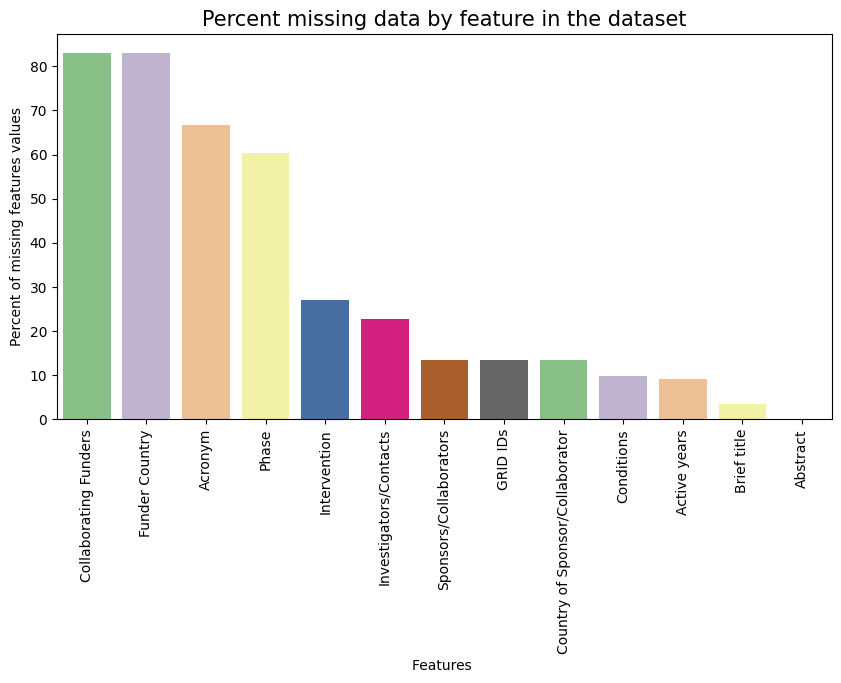

In [5]:
f, ax = plt.subplots(figsize=(10, 5))
plt.xticks(rotation='vertical')
sns.barplot(x=data_nan.index, y=data_nan, palette=("Accent"))
plt.xlabel('Features ', fontsize=10)
plt.ylabel('Percent of missing features values', fontsize=10)
plt.title('Percent missing data by feature in the dataset', fontsize=15)

In [6]:
print('Total numbers of rows in data {} and features are {}'.format(data.shape[0], data.shape[1]))

Total numbers of rows in data 10666 and features are 21


In [7]:
data['Abstract'][0]

'The aim was to determine the coronavirus anxiety levels and emotional eating status of cases with diagnosis of MetS according to diagnostic criteria published by the International Diabetic Federation (IDF) in 2005 and healthy individuals with similar BMI to MetS subjects.\n\nDetailed Description\nThe aim was to determine the coronavirus anxiety levels and emotional eating status of cases with diagnosis of MetS according to diagnostic criteria published by the International Diabetic Federation (IDF) in 2005 and healthy individuals with similar BMI to MetS subjects. This study was completed with the descriptive, cross-sectional and relational screening model. The full sampling method was used in the study. The study was completed with 105 individuals with metabolic syndrome attending the diet clinic and 109 healthy individuals without MetS diagnosis also attending the diet clinic. Collection of data used anthropometric measurements and biochemical findings, blood pressure and a survey f

In [8]:
## Drop the rows where the abstract is Nan.
data.dropna(subset=['Abstract'], inplace=True)

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [10]:
# function to remove all urls
from tqdm import tqdm
class Text_cleaning:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        
    def remove_urls(self, text):
        try:
            new_text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
            return new_text
        except:
            return text

    # make all text lowercase
    def text_lowercase(self, text):
        try:
            return text.lower()
        except:
            return text
    
    # remove numbers
    def remove_numbers(self, text):
        try:
            result = re.sub(r'\d+', '', text)
            return result
        except:
            return text
    
    # remove punctuation
    def remove_punctuation(self, text):
        try:
            translator = str.maketrans('', '', string.punctuation)
            return text.translate(translator)
        except:
            return text
    
    # tokenize
    def tokenize(self, text):
        try:
            text = word_tokenize(text)
            return text
        except:
            return text
    
    # remove stopwords
    
    def remove_stopwords(self, text):
        try:
            text = [i for i in text if not i in self.stop_words]
            return text
        except:
            return text
    
    # lemmatize Words 
    
    def lemmatize(self, text):
        try:
            text = [self.lemmatizer.lemmatize(token) for token in text]
            return text
        except:
            return text

    #Creating one function so that all functions can be applied at once
    def preprocessing(self, data, columns):
        for i in tqdm(range(data.shape[0])):
            text = data.iloc[i][columns]
            text = self.remove_urls(text)
            text = self.remove_numbers(text)
            text = self.text_lowercase(text)
            text = self.remove_punctuation(text)
            text = self.tokenize(text)
            text = self.remove_stopwords(text)
            text = self.lemmatize(text)
            text = ' '.join(text)
            text = text.replace('\n',' ') 
            data.iloc[i][columns] = text
        data[columns] = data[columns].apply(str)
        return data

In [11]:
text_clean = Text_cleaning()
data = text_clean.preprocessing(data, 'Abstract')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10664/10664 [00:13<00:00, 788.43it/s]


In [12]:
data['Abstract'][0]

'aim determine coronavirus anxiety level emotional eating status case diagnosis mets according diagnostic criterion published international diabetic federation idf healthy individual similar bmi mets subject detailed description aim determine coronavirus anxiety level emotional eating status case diagnosis mets according diagnostic criterion published international diabetic federation idf healthy individual similar bmi mets subject study completed descriptive cross sectional relational screening model full sampling method used study study completed individual metabolic syndrome attending diet clinic healthy individual without mets diagnosis also attending diet clinic collection data used anthropometric measurement biochemical finding blood pressure survey form coronavirus anxiety scale ca emotional eating scale ee'

In [15]:
from collections import Counter
cnt = Counter()
for text in data["Abstract"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('patient', 38457),
 ('covid', 38211),
 ('study', 31963),
 ('group', 12771),
 ('treatment', 12471),
 ('day', 12337),
 ('sars', 11600),
 ('cov', 11540),
 ('clinical', 11507),
 ('disease', 11395)]

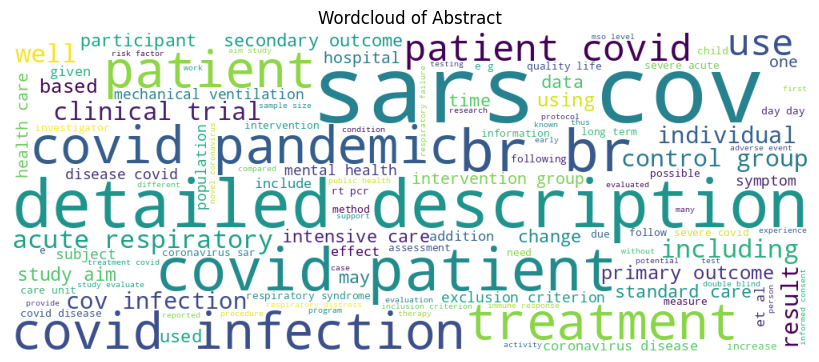

In [21]:
#Final word cloud after all the cleaning and pre-processing
from wordcloud import WordCloud
from nltk.corpus import stopwords
wordcloud = WordCloud(width = 1000, height = 400, 
            background_color ='white',  
            min_font_size = 10).generate(" ".join(data['Abstract'].astype(str))) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title('Wordcloud of Abstract')
plt.tight_layout(pad = 0) 

plt.show() 

## Title

In [13]:
#Applying preprocessing and removing '\n' character
data = text_clean.preprocessing(data, 'Title')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10664/10664 [00:02<00:00, 4568.98it/s]


In [14]:
data['Title'][0]

'The Relationship Between Coronavirus Anxiety Level and Emotional Eating in Individuals With Metabolic Syndrome'

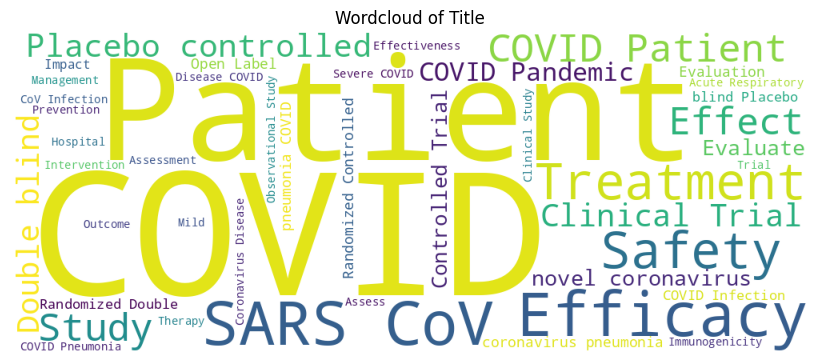

In [20]:
#Final word cloud after all the cleaning and pre-processing
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1000, height = 400, 
            background_color ='white', 
            min_font_size = 10).generate(" ".join(data['Title'].astype(str))) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title('Wordcloud of Title')
plt.tight_layout(pad = 0) 

plt.show() 